In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [2]:
# Import the necessary libraries.
import statistics
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
% matplotlib inline
import seaborn as sns

In [3]:
# Import the raw wiretapping data (sourced from https://www.kaggle.com/eff/california-wire-tapping)
# Information here: https://www.eff.org/deeplinks/2017/06/california-finally-releases-wiretap-dataset
# State report here: https://www.eff.org/files/2017/06/09/2016_ca_electronic_interceptions_report.pdf
wt_data = pd.read_csv('/Users/guest/Desktop/Capstone/california_wt2_export_2016.csv')

# Add a column for total cost.
wt_data['TotalCost'] = wt_data['PersonnelCost'] + wt_data['ResourceCost']

# Replace nans with 0s in the arrested and incriminating interception columns where appropriate.
wt_data['Arrested'] = np.nan_to_num(wt_data['Arrested'])
wt_data['Incriminating'] = np.nan_to_num(wt_data['Incriminating'])

# Add a binary column for arrests.
wt_data['Arrested_Binary'] = wt_data['Arrested'] > 0
wt_data['Arrested_Binary'] = wt_data['Arrested_Binary'] * 1

# Add a binary column for interception of incriminating materials.
wt_data['Incriminating_Binary'] = wt_data['Incriminating'] > 0
wt_data['Incriminating_Binary'] = wt_data['Incriminating_Binary'] * 1

# Add a column that codes cost ordinally

arrest_recode = []

for row in wt_data['Arrested']:
    if row == 0:
        arrest_recode.append('0')
    elif row > 0 and row <= 5:   
        arrest_recode.append('1 - 5')
    elif row > 5 and row <= 10:   
        arrest_recode.append('6 - 10')
    elif row > 10 and row <= 15:   
        arrest_recode.append('11 - 15')
    elif row > 15 and row <= 20:
        arrest_recode.append('15 - 20')
    elif row > 20:
        arrest_recode.append('> 21')
        
wt_data['Arrest_Recode'] = arrest_recode

In [4]:
# Import county population data (sourced from http://www.dof.ca.gov/Forecasting/Demographics/Estimates/E-1/)
county_pop = pd.read_csv('/Users/guest/Desktop/Capstone/CA_county_population.csv', index_col=0)

In [5]:
# Marker styles and colors for later use.
markers = ['.', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff', '#aa6e28', '#800000', '#aaffc3', '#808000', '#000080']

In [6]:
# Calculate correlation coefficients. 
cost_arrest_r = round(mstats.pearsonr(wt_data['TotalCost'], wt_data['Arrested'])[0],3) # overall cost / arrests
cost_incriminating_r = round(mstats.pearsonr(wt_data['TotalCost'], wt_data['Incriminating'])[0],3) # overall cost / incriminating interceptions
incriminating_arrest_r= round(mstats.pearsonr(wt_data['Incriminating_Binary'], wt_data['Arrested_Binary'])[0],3) # presence or absence of incriminating messages / presence or absence of arrest
incriminating_arrest_p= round(float(mstats.pearsonr(wt_data['Incriminating_Binary'], wt_data['Arrested_Binary'])[1]),4) # presence or absence of incriminating messages / presence or absence of arrest

In [7]:
# Calculate the trend line for the relationship between expenditures and arrests.
arrest_z = np.polyfit(wt_data['TotalCost'], wt_data['Arrested'], 1)
arrest_p = np.poly1d(arrest_z)

# Calculate the trend line for the relationship between incriminating interceptions and arrests.
incriminating_z = np.polyfit(wt_data['TotalCost'], wt_data['Incriminating'], 1)
incriminating_p = np.poly1d(incriminating_z)

In [8]:
# JURISDICTION DATAFRAME

all_jurisdictions = wt_data['Jurisdiction'].unique()

# Store overall data in lists for later conversion to dataframe.
jurisdiction = ['Overall'] # Jurisdiction names
pop = [] # Populations of each jurisdiction
jur_freqs = [wt_data.shape[0]] # Number of cases
jur_persons = [wt_data['Persons'].sum()] # Number of people tapped
jur_costs = [wt_data['TotalCost'].sum()] # Expenditures
arrest_corr = [cost_arrest_r] # Correlation coefficient (cost & arrests)
incriminating_corr = [cost_incriminating_r] # Correlation coefficient (cost & incriminating intercepts)
dummy_zero = [0] # To allow for one-dimensional plotting of correlation coefficients
label_shape = ['o'] # To allow for consistent labeling throughout plots.
label_color = ['black'] # To allow for consistent labeling throughout plots.

# Calculate and store jurisdiction-specific data
label_count = 0

for county in all_jurisdictions: 
    
    # Select the jurisdiction's cases only.
    county_corr_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == county, :]    
    
    # Log jurisdiction, valid n, and dummy zero.
    jurisdiction.append(county)
    pop.append(county_pop.get_value(county,'01_16_population'))
    jur_freqs.append(county_corr_slice.shape[0])
    dummy_zero.append(0)
    
    # Log the sum of wiretapping costs
    sum_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == county, :]
    jur_costs.append(sum_slice['TotalCost'].sum())
    jur_persons.append(sum_slice['Persons'].sum())
        
    # Assign color and marker styles to the jurisdiction.
    label_shape.append(markers[label_count])
    label_color.append(colors[label_count])
    label_count = label_count + 1
    
    # Log correlations or, if appropriate, blanks.
    if county_corr_slice.shape[0] <= 50:
        arrest_corr.append(np.nan)
        incriminating_corr.append(np.nan)
    else:
        arrest_corr.append(mstats.pearsonr(county_corr_slice['TotalCost'], county_corr_slice['Arrested'])[0])
        incriminating_corr.append(mstats.pearsonr(county_corr_slice['TotalCost'], county_corr_slice['Incriminating'])[0])

# Add population to the 'Overall' column
pop_total = sum(pop)
pop.insert(0, pop_total)        


jur_perc_str = []
for freq in jur_freqs:
    freq_per = str(round(100 * (freq / wt_data.shape[0]),1)) + '%'
    jur_perc_str.append(freq_per)

# Store the jurisdiction data in a dataframe.      
jurisdiction_data = pd.DataFrame()
jurisdiction_data['jurisdiction'] = jurisdiction
jurisdiction_data = jurisdiction_data.set_index(['jurisdiction'])

jurisdiction_data['jur_id'] = range(len(jurisdiction_data))
jurisdiction_data['pop'] = pop
jurisdiction_data['valid_n'] = jur_freqs
jurisdiction_data['freq_per_cap'] = jurisdiction_data['valid_n']/jurisdiction_data['pop']
jurisdiction_data['persons'] = jur_persons

# Remove the incorrectly entered 'persons' values from analysis.
error_slice = wt_data.loc[lambda df: wt_data['Persons'] == wt_data['Communications'], :]
error_slice = error_slice.loc[lambda df: error_slice['Persons'] > 50, :]
jurisdiction_data.loc['Riverside','persons'] = jurisdiction_data.loc['Riverside','persons'] - error_slice['Persons'].sum()

jurisdiction_data['persons_per_cap'] = jurisdiction_data['persons']/jurisdiction_data['pop']
jurisdiction_data['cost'] = jur_costs
jurisdiction_data['cost_per_cap'] = jurisdiction_data['cost']/jurisdiction_data['pop']
jurisdiction_data['arrest_corr'] = arrest_corr
jurisdiction_data['incriminating_corr'] = incriminating_corr
jurisdiction_data['dummy_zero'] = dummy_zero
jurisdiction_data['perc'] = (jurisdiction_data['valid_n'] / wt_data.shape[0])
jurisdiction_data['perc_str'] = jur_perc_str
jurisdiction_data['shape'] = label_shape
jurisdiction_data['color'] = label_color

In [9]:
from scipy.stats import ttest_1samp, mannwhitneyu, normaltest

counts = []
means = []
stdev = []
normal = []
mannwhitneyu_statistic = []
mannwhitneyu_p = []

for jurisdiction in all_jurisdictions:
    wt_plot_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == jurisdiction, :]

    counts.append(wt_plot_slice.shape[0])
    means.append(wt_plot_slice['TotalCost'].mean())
    stdev.append(np.std(wt_plot_slice['TotalCost']))  
    
    if wt_plot_slice.shape[0] > 20:
        mannwhitneyu_statistic.append(mannwhitneyu(wt_plot_slice['TotalCost'], wt_data['TotalCost'])[0])
        mannwhitneyu_p.append(mannwhitneyu(wt_plot_slice['TotalCost'], wt_data['TotalCost'])[1])
        if normaltest(wt_plot_slice['TotalCost'])[1] < 0.05: normtf = False
        else: normtf = False
        normal.append(normtf)

    else:
        mannwhitneyu_statistic.append(float('NaN'))
        mannwhitneyu_p.append(float('NaN'))
        normal.append(float('NaN'))
        
hypothesis = pd.DataFrame()
hypothesis['jur'] = all_jurisdictions
hypothesis['count']= counts
hypothesis['mean']= means
hypothesis['stdev'] = stdev
hypothesis['normal'] = normal
hypothesis['mannwhitneyu'] = mannwhitneyu_statistic
hypothesis['mannwhitneyup'] = mannwhitneyu_p

mannwhitneyusig = []

for row in hypothesis['mannwhitneyup']:
    if row < 0.05:
        mannwhitneyusig.append(True)
    else:
        mannwhitneyusig.append(False)

hypothesis['mannwhitneyusig'] = mannwhitneyusig
hypothesis = hypothesis.set_index(hypothesis['jur'])


In [10]:
# JUDGE DATA DATAFRAME

jurisdiction_indexes = {}

for jurisdiction in wt_data['Jurisdiction'].unique():
    all_jurisdictions = list(wt_data['Jurisdiction'].unique())
    jurisdiction_indexes[jurisdiction] = all_jurisdictions.index(jurisdiction)

sum_total = 0

judges = []
judge_costs = []
jurisdiction_list = []
jurisdiction_pop = []
y_position = []
numeric_judge =[]
cases = []
judge_color = []

for judge_var in wt_data['Judge'].unique():
    judge_plot_slice = wt_data.loc[lambda df: wt_data['Judge'] == judge_var, :]
    for county in judge_plot_slice['Jurisdiction'].unique():
        n_cases = judge_plot_slice.loc[lambda df: judge_plot_slice['Jurisdiction'] == county, :].shape[0]
        judges.append(judge_var)
        jurisdiction_pop.append(jurisdiction_data.get_value(county,'pop'))
        jurisdiction_list.append(county)
        cases.append(n_cases)
        judge_costs.append(judge_plot_slice['TotalCost'].sum())
        y_position.append(jurisdiction_indexes.get(county))
        judge_color.append(jurisdiction_data.get_value(county,'color'))
        
judge_data = pd.DataFrame()
judge_data['judge'] = judges
judge_data['jur_pop'] = jurisdiction_pop
judge_data['jurisdiction'] = jurisdiction_list
judge_data['n_cases'] = cases
judge_data['cost'] = judge_costs
judge_data['cost_per_cap'] = judge_data['cost']/judge_data['jur_pop']
judge_data['y_pos'] = y_position
judge_data['color'] = judge_color

In [11]:
# COMMUNICATION METHOD DATAFRAME

# The intercept locations are split across several columns; consolidate them.
intercept_variables = ('InterceptOne', 'InterceptTwo', 'InterceptThree', 'InterceptFour')
intercept_types = []
intercept_freqs = []

# Create a list of unique intercept types.
for var in intercept_variables:
    intercept_types.extend(wt_data[var])
intercept_types = list([x for x in list(set(intercept_types)) if str(x) != 'nan'])

# Define "other" variable and sum across all columns.
other_freq = 0
other_types = []

for int_type in intercept_types:
    in1 = wt_data.loc[lambda df: wt_data['InterceptOne'] == int_type, :].shape[0]
    in2 = wt_data.loc[lambda df: wt_data['InterceptTwo'] == int_type, :].shape[0]
    in3 = wt_data.loc[lambda df: wt_data['InterceptThree'] == int_type, :].shape[0]
    in4 = wt_data.loc[lambda df: wt_data['InterceptFour'] == int_type, :].shape[0]
    total = in1 + in2 + in3 + in4
    
    if total < 50:
        other_freq = other_freq + total
        other_types.append(int_type)
    
    else:
        intercept_freqs.append(total)


intercept_types = list([x for x in list(set(intercept_types)) if str(x) not in other_types])

intercept_types.append('Other Mode of Communication*')
intercept_freqs.append(other_freq)

int_perc_str = []
for freq in intercept_freqs:
    freq_per = str(round(100 * (freq / wt_data.shape[0]),1)) + '%'
    int_perc_str.append(freq_per)

# Consolidate these lists into a dataframe.
intercept_data = pd.DataFrame()
intercept_data['int_type'] = intercept_types
intercept_data['int_id'] = np.arange(len(intercept_freqs))
intercept_data['int_freq'] = intercept_freqs
intercept_data['perc'] = (intercept_data['int_freq'] / wt_data.shape[0])
intercept_data['perc_str'] = int_perc_str
intercept_data['label'] = intercept_data['int_type'] + ' (' + intercept_data['perc_str'] + ')'
intercept_data = intercept_data.set_index(intercept_data['int_type'])


# 2016 State and Local-Level Wiretapping in California

<hr>

## <u>Introduction</u>

In 2016, the state of California spent __\$29,696,300__ on wiretapping __181,059__ people across __17__ counties. These wiretapping operations led to __776__ arrests. <a href="https://www.eff.org/deeplinks/2017/06/california-finally-releases-wiretap-dataset">2016 marks the first year that the California Department of Justice (CADOJ) has ever released its wiretapping data in spreadsheet form</a>. In previous years, the CADOJ rendered independent analysis and year-to-year benchmarking extremely difficult by only releasing its data in the form of MS Word files, locked PDFs, and agency reports. This shift towards transparency follows years of pressure from the Electronic Freedom Foundation, and opens the door for more independent analyses.

This report will examine California state-level wiretapping in detail. Section one describes the types of wiretapping that were approved – their scope and scale, what criminal offenses were most used as justification for their execution, and what modes of communication were most commonly targeted. Section two turns an eye towards wiretapping rates, spending, and approval by jurisdiction. Finally, section three examines the criminal justice outcomes of wiretapping – the relationships between spending, interception of incriminating communication, and arrest; the relationship between arrests, criminal offense, and spending; and the proportion of people surveilled in cases that did not lead to any arrests.<br>

The data used in this report was <a href='https://www.kaggle.com/eff/california-wire-tapping'>sourced here</a>.

__Note:__ Five cases in the dataset (reproduced below) report unusually large numbers of persons surveilled because of what appears to be a clerical error. These records have been removed from analyses that factor in number of persons surveilled, but included in analyses that do not. Accordingly, the number of persons surveilled in Riverside county cases is underreported by an unknown amount. Riverside county is known to have an extensive wiretapping program – <a href='https://www.usatoday.com/story/news/crime_courts/2016/07/06/riverside-county-wiretaps-judge/86779116/'>it was recently repudiated in Federal court for failing to abide by approval regulations, and at one point accounted for 1/5 of all wiretaps in the United States</a>. Given this context, the gap in the data created by this error is particularly alarming.

In [66]:
print(error_slice[['EICOSNumber','Jurisdiction','TotalDays','Communications','Persons','TotalCost']])

       EICOSNumber Jurisdiction  TotalDays  Communications  Persons  TotalCost
335  2016-RIV-2252    Riverside         30           450.0    450.0      20148
348  2016-RIV-2260    Riverside         30          5838.0   5838.0      31224
352  2016-RIV-2265    Riverside         30           472.0    472.0      31224
379  2016-RIV-2293    Riverside        150         91116.0  91116.0     266000
407  2016-RIV-2321    Riverside         30           818.0    818.0      70284


<hr>

## <u>Section 1: What types of wiretapping were approved at the state level?</u>

This section of the report describes the scope and duration of state and local-level California wiretaps in 2016, as well as the alleged offenses that these wiretaps were approved to address and the various modes of communication that were targeted for surveillance.

### 1a: Number of People Wiretapped per Case

In 2016, __82,365__ people across __569__ cases were wiretapped at the state or local level in California. The median number of persons authorized for wiretapping in any given case was __52__, and large-scale authorizations were commonplace – fully __30.0%__ of all cases authorized the surveillance of 100 or more persons. Figure 1 details the distribution of persons wiretapped across all 569 cases.

###### Notable Findings:
*  Together, the five investigations that authorized the largest-scale wiretapping surveilled __14,599__ persons – __17.7%__ of everyone wiretapped at the state level in California in 2016. None of these five cases led to any arrests.


* One Los Angeles County investigation intercepted __4,600__ people's text messages over 330 days. This case did not lead to any arrests.

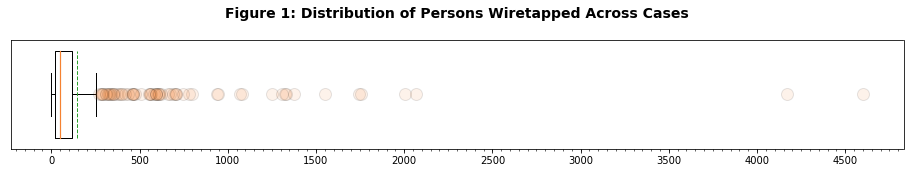

In [67]:
# Number of People Surveilled

cleaned_bplot = wt_data.copy().drop([223, 263, 313, 484, 496] + list(error_slice.index))

plt.figure(figsize=(16,2))

medianprops = dict(linestyle='-', linewidth=1.2, color='#f58231')
flierprops = dict(marker='o', markerfacecolor='#f58231', markersize=12, linestyle='none', alpha=.1)

plt.boxplot(cleaned_bplot['Persons'],
            showmeans=True,
            meanline=True,
            vert=False,
            widths=.8,
            flierprops=flierprops,
            medianprops=medianprops)

plt.title('Figure 1: Distribution of Persons Wiretapped Across Cases\n', fontsize=14, fontweight='bold')

ax = plt.axes()

ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

ax.yaxis.set_ticks([])

plt.show()

### 1b: Duration of Wiretap

In __45.7%__ of all 2016 state and local-level wiretapping cases, wiretapping operations lasted 30 days. Because operational extensions are authorized in 30 day increments, most remaining cases lasted 60 (__9.1%__), 90 (__4.0%__) , or 120 (__2.3%__) days. Figure 2 is a histogram describing the distribution of wiretap durations across all cases.

###### Notable Findings:
* There were seven wiretapping operations that lasted longer than 125 days. Together, they cost __$925,647__, surveilled __7,139__ persons, and led to __0__ arrests.


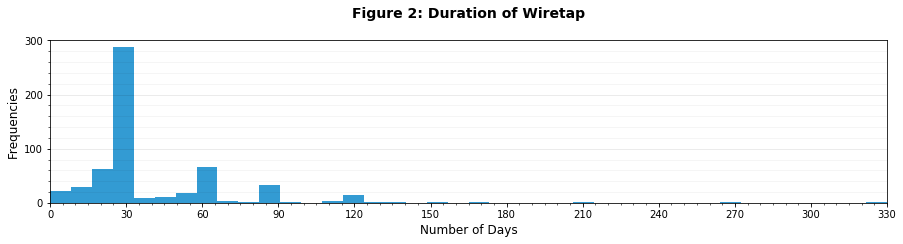

In [68]:
# Duration of Surveillance

cleaned_hist = wt_data.loc[lambda df: pd.isnull(wt_data['TotalDaysUsed']) == False, :]


plt.figure(figsize=(15,3))

plt.hist(cleaned_hist['TotalDaysUsed'], color='#0082c8', bins=40, alpha=0.8)

plt.title('Figure 2: Duration of Wiretap\n', fontsize=14, fontweight='bold')

ax = plt.axes()
ax.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax.set_ylabel('Frequencies', fontsize=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))

ax.set_xlabel('Number of Days', fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim(min(cleaned_hist['TotalDaysUsed']), max(cleaned_hist['TotalDaysUsed']))

plt.show()\

### 1c: Alleged Offense

In 2016, __76.6%__ of California state and local-level wiretapping cases were authorized to aid narcotics investigations. The remaining cases were authorized to aid murder (__18.8%__), gang (__3.9%__), and human trafficking (__0.7%__) investigations. Figure 3 describes the frequency and proportion of wiretapping by alleged offense.

###### Notable Findings:
* Narcotics investigations alone entailed the surveillance of __142,945__ persons. __76.8%__ of these cases did not lead to arrest.

### 1d: Mode of Communication

In the vast majority of cases (__81.2%__), state and local-level wiretapping operations intercepted communications from cellular/mobile phones. __32.0%__ intercepted text messages, __14.9%__ intercepted communication from wired telephones, and __6.3%__ targeted voicemail, Whatsapp, personal computer, Facebook, or Blackberry Messenger. Figure 4 details the distribution of communication mode targeted.

###### Notable Findings:

* __26.2%__ of cases targeted two modes of communication,  __3.9%__ targeted three modes of communication, and __0.5%__ targeted four modes of communication.


* __57.3%__ of cases that targeted more than one mode of communication did not lead to arrest

<br><br>

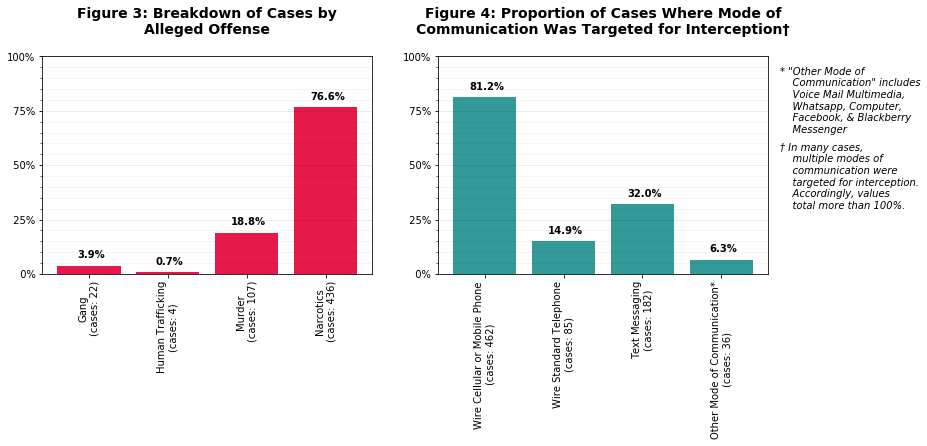

In [69]:
# Mode of Communication Intercepted

fig = plt.figure(figsize=(13,4))


# Crime
ax1 = fig.add_subplot(1,2,1)

offense_slice = wt_data.groupby('Offense').size().copy().to_frame()
offense_slice.columns = ['frequency']
offense_slice['percent'] = offense_slice['frequency']/offense_slice['frequency'].sum()
offense_slice['identifier'] = range(1, len(offense_slice) + 1)

plt.bar(offense_slice['identifier'], offense_slice['percent'], width=0.8, color='#e6194b')

ax1.set_title('Figure 3: Breakdown of Cases by\nAlleged Offense\n', fontsize=14, fontweight='bold')

crime_x_coord = {'Gang': 0, 'Human Trafficking':1, 'Murder':2, 'Narcotics':3}

offense_labels = ['']

for crime in wt_data['Offense'].unique():
    x = crime_x_coord[crime] + 1
    y = offense_slice.get_value(crime,'percent')
    label = str(round(y*100,1)) + '%'
    offense_labels.append(crime + '\n(cases: ' + str(offense_slice.get_value(crime,'frequency')) + ')')
    plt.text(x+.025,y+.05,label,weight='semibold', va='center', ha='center')
    
ax1.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xticklabels(sorted(offense_labels), rotation=90)

ax1.set_ylim(0, 1)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(.25))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


# Intercept Type
ax2 = fig.add_subplot(1,2,2)

plt.bar(intercept_data['int_id'], intercept_data['perc'], alpha= 0.8, color='#008080')

ax2.set_title('Figure 4: Proportion of Cases Where Mode of\nCommunication Was Targeted for Interception†\n', fontsize=14, fontweight='bold')

int_labels = ['']
for var in intercept_data['int_type']:
    x = intercept_data.get_value(var,'int_id')
    y = intercept_data.get_value(var,'perc')
    label = intercept_data.get_value(var,'perc_str')
    int_labels.append(var + '\n(cases: ' + str(intercept_data.get_value(var,'int_freq')) + ')')
    plt.text(x+.025,y+.05,label,weight='semibold', va='center', ha='center')

ax2.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xticklabels(labels=int_labels, rotation=90)

ax2.set_ylim(0,1)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(.25))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

footnote1 = '* "Other Mode of\n    Communication" includes\n    Voice Mail Multimedia,\n    Whatsapp, Computer,\n    Facebook, & Blackberry\n    Messenger'
footnote2 = '† In many cases,\n    multiple modes of\n    communication were\n    targeted for interception.\n    Accordingly, values\n    total more than 100%.'
ax2.text(3.74,.65,footnote1, fontsize=10, style='italic')
ax2.text(3.74,.30,footnote2, fontsize=10, style='italic')

plt.show()

<hr>

## <u>Question 2: How do wiretapping approvals and expenditures vary by jurisdiction?</u>

### 2a: Wiretapping Rates and Frequencies Across Jurisdictions

In 2016, __569__ California state and local-level cases authorized the wiretap surveillance of  __82,365__ persons. This occurred across 17 jurisdictions with a total population of __31,831,636__, translating to a rate of __1.79__ cases and __258.75__ persons per 100,000 residents. Figure 5 summarizes the per-capita rates of state and local-level wiretapping across all jurisdictions in California where it occurred in 2016, and Figure 6 summarizes the frequencies of wiretapping cases across jurisdictions and offenses.<br><br>


__Note:__ It is impossible to rule out cases in this dataset in which the same person was wiretapped multiple times across multiple cases. Accordingly, references to "number of persons" in this report do not necessarily describe _individual_ persons.

###### Notable Findings:

* The highest per capita rate of state and local-level wiretapping of all California jurisdictions occurred in Ventura County, where wiretap surveillance on __12,509__ persons was authorized in a population of just __843,893__. This translates to __2.11__ cases and __1,464.94__ persons per 100,000 residents, or __1.46%__ of the county's overall population.


* Although __38.8%__ (221) of California's 569 state and local-level wiretapping cases took place in Los Angeles, its wiretapping rate per capita is comparable to California's overall rate. The majority of Los Angeles wiretapping is authorized for narcotics investigations.



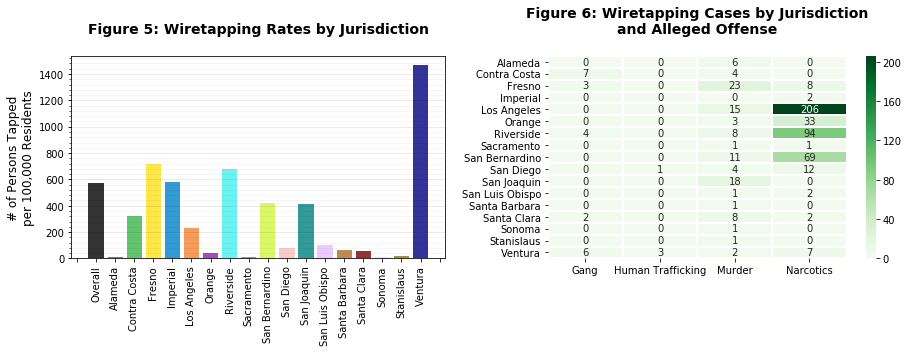

In [70]:
tick_labels = ['','']
for county in jurisdiction_data.index:
    tick_labels.append(county)

tick_labels2 = ['','']
for county in jurisdiction_data.index[1:]:
    tick_labels2.append(county)

approval_data = pd.pivot_table(wt_data, 
                         values='EICOSNumber',
                         index=['Jurisdiction'], 
                         columns=['Offense'], 
                         aggfunc='count').fillna(0)


fig = plt.figure(figsize=(13,5))

    
ax1 = fig.add_subplot(1,2,1)
ax1.bar(jurisdiction_data['jur_id'],
        jurisdiction_data['persons_per_cap']*100000,
        color=jurisdiction_data['color'],
        alpha=0.8)
ax1.set_title('Figure 5: Wiretapping Rates by Jurisdiction\n', fontsize=14, fontweight='bold')
ax1.set_ylabel('# of Persons Tapped\nper 100,000 Residents', fontsize=12)
ax1.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax1.set_xticklabels(labels=tick_labels, rotation=90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(40))




ax2 = fig.add_subplot(1,2,2)

sns.heatmap(approval_data,
                 annot=True,
                 fmt='g',
                 linewidths=1,
                 center=100,
                 cmap='Greens')

ax2.set_title('Figure 6: Wiretapping Cases by Jurisdiction\nand Alleged Offense\n', fontsize=14, fontweight='bold')
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('', fontsize=12)



plt.tight_layout()

plt.show()

### 2b: Wiretap Spending by Jurisdiction and Approving Judge

In 2016, state and local-level law enforcement across California spent a total of __\$29,696,300__ on wiretapping, averaging a total of __\$52,190__ per case and __\$93,292__ per hundred thousand residents. Figure 7 summarizes total and per capita wiretap spending by jurisdiction and approving judge. 

Additionally, a Mann-Whitney U test was used to check for statistically significant between-jurisdiction differences in expenditure per case. These findings are summarized in Figure 7's legend – counties marked with a "-" spent significantly less per case than the state average, while counties marked with a "+" spent significantly more.

###### Notable Findings:

* Los Angeles County approved the most wiretap spending of any jurisdiction (__\$10.2M__), while Riverside County approved the most wiretap spending per capita (__$293,945__ per hundred thousand residents) of any jurisdiction.


* Los Angeles (p < 0.01)  and Orange County (p < 0.01) judges approved significantly less spending per case than the state average, while Riverside (p < 0.01) and San Bernardino (p < 0.01) County judges approved significantly ___more___ _spending per case than the state average._

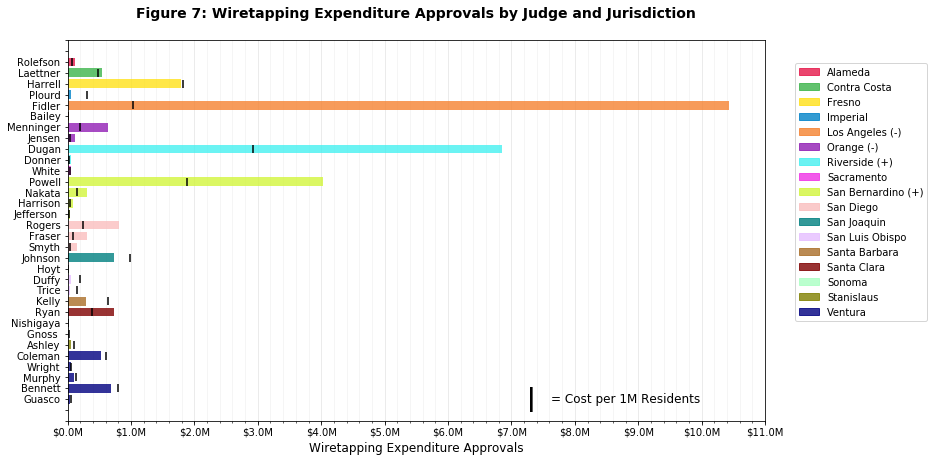

In [75]:
# Cost by Location and Judge

plt.figure(figsize=(12.5,7))

plt.scatter(judge_data['cost_per_cap']*1000000, judge_data.index[::-1], color='black', marker='|', s=80, zorder=3)
plt.barh(judge_data.index[::-1], judge_data['cost'], color=judge_data['color'], alpha=0.8, zorder=2)

# Axis Labels
plt.title('Figure 7: Wiretapping Expenditure Approvals by Judge and Jurisdiction\n', fontsize=14, fontweight='bold')
plt.xlabel('Wiretapping Expenditure Approvals', fontsize=12)


# Format Ticks
tick_labels = ['','']
for judge in judge_data['judge'][::-1]:
    tick_labels.append(judge)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

formatter = ticker.FuncFormatter(millions)

ax = plt.axes()
ax.grid(b=None, which='both', axis='x', color='black', alpha=0.05, zorder=0)
ax.set_xlim(0,11000000)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(200000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_yticklabels(labels=tick_labels)

# Format Index
judge_location_patches = {}

for jurisdiction in all_jurisdictions:
    key = jurisdiction.replace(' ','_').lower() + '_judge_label'
    sig_tf = hypothesis.get_value(jurisdiction,'mannwhitneyusig')
    if sig_tf == True:
        if hypothesis.get_value(jurisdiction,'mean') - wt_data['TotalCost'].mean() < 0:
            value = jurisdiction + ' (-)'
        else:
            value = jurisdiction + ' (+)'
    else:
        value = jurisdiction
    judge_location_patches[key] = value

    
alameda_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Alameda','color'),
                             label=judge_location_patches['alameda_judge_label'],alpha=0.8)
contra_costa_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Contra Costa','color'),
                             label=judge_location_patches['contra_costa_judge_label'],alpha=0.8)
fresno_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Fresno','color'),
                             label=judge_location_patches['fresno_judge_label'],alpha=0.8)
imperial_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Imperial','color'),
                             label=judge_location_patches['imperial_judge_label'],alpha=0.8)
los_angeles_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Los Angeles','color'),
                             label=judge_location_patches['los_angeles_judge_label'],alpha=0.8)
orange_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Orange','color'),
                             label=judge_location_patches['orange_judge_label'],alpha=0.8)
riverside_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Riverside','color'),
                             label=judge_location_patches['riverside_judge_label'],alpha=0.8)
sacramento_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Sacramento','color'),
                             label=judge_location_patches['sacramento_judge_label'],alpha=0.8)
san_bernardino_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Bernardino','color'),
                             label=judge_location_patches['san_bernardino_judge_label'],alpha=0.8)
san_diego_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Diego','color'),
                             label=judge_location_patches['san_diego_judge_label'],alpha=0.8)
san_joaquin_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Joaquin','color'),
                             label=judge_location_patches['san_joaquin_judge_label'],alpha=0.8)
san_luis_obispo_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Luis Obispo','color'),
                             label=judge_location_patches['san_luis_obispo_judge_label'],alpha=0.8)
santa_barbara_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Santa Barbara','color'),
                             label=judge_location_patches['santa_barbara_judge_label'],alpha=0.8)
santa_clara_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Santa Clara','color'),
                             label=judge_location_patches['santa_clara_judge_label'],alpha=0.8)
sonoma_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Sonoma','color'),
                             label=judge_location_patches['sonoma_judge_label'],alpha=0.8)
stanislaus_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Stanislaus','color'),
                             label=judge_location_patches['stanislaus_judge_label'],alpha=0.8)
ventura_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Ventura','color'),
                             label=judge_location_patches['ventura_judge_label'],alpha=0.8)

plt.legend(handles=[alameda_judge_label, contra_costa_judge_label, fresno_judge_label, imperial_judge_label, 
                     los_angeles_judge_label, orange_judge_label, riverside_judge_label, sacramento_judge_label, 
                     san_bernardino_judge_label, san_diego_judge_label, san_joaquin_judge_label, 
                     san_luis_obispo_judge_label, santa_barbara_judge_label, santa_clara_judge_label, 
                     sonoma_judge_label, stanislaus_judge_label, ventura_judge_label],
                     loc='center right',
                    bbox_to_anchor=(1.24, .6))

plt.text(7250000,.02,'|', fontsize=24, weight='bold', va='center')
plt.text(7630000,.02,'= Cost per 1M Residents', fontsize=12, va='center')
plt.show()

<hr>

## <u>Question 3: How do wiretapping expenditures relate to law enforcement outcomes?</u>
As of the release of the dataset used for these analyses, all 2016 California state and local-level wiretapping operations combined had yielded __776__ arrests and only __27__ convictions. Because complex criminal trials can take years to resolve, convictions to date were not deemed appropriate for use as a means of quantifying wiretapping outcome in this analysis. Instead, a variety of other measures were taken into account: the relationships between spending, interception of communications classed as incriminating, and arrests; the proportion of people surveilled in cases that lead to arrest relative to people surveilled in cases that did not; and the relationship between alleged offense, arrest, and spending.

### 3a: Total Cost vs. Number of Incriminating Intercepts & Number of Arrests

In 2016, state and local law enforcement agencies in California spent __\$29,696,300__ to intercept __7,794,701__ communications via wiretapping across . __18.7%__ of these cases intercepted communications were classified as incriminating, and 27.9% of them led to one or more arrests. A small (__r = 0.18__) but significantly significant correlation was observed between total operation cost and interception of incriminating intercepts, and a medium-sized statistically significant correlation (__r = 0.35__) was observed between total operation cost and number of arrests. These relationships are likely related to the fact that more expensive cases tended to last longer (__r = 0.26__) and wiretap more people (__r = 0.28__) than less expensive cases. 

Figure 9 summarizes the relationship between operation cost and number of incriminating communications intercepted, while figure 10 summarizes the relationship between operation cost and number of arrests. The legends in both figures include county-level correlation coefficients for jurisdictions where 50 or more wiretapping operations were conducted.

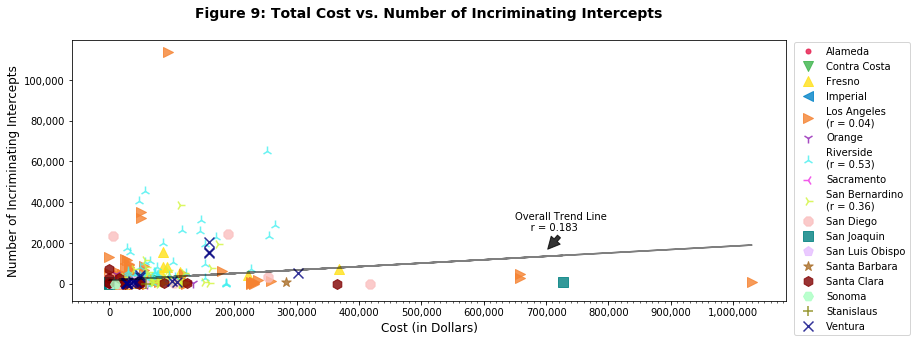

In [76]:
# Plot the incriminating interceptions correlation chart
plt.figure(figsize=(12.8,4.8))

for jurisdiction in all_jurisdictions:
    
    jurisdiction_plot_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == jurisdiction, :]
    
    if pd.notnull(jurisdiction_data.get_value(jurisdiction,'incriminating_corr')) == True:
        setlabel = jurisdiction + '\n(r = ' + str(round(jurisdiction_data.get_value(jurisdiction,'incriminating_corr'),2)) + ')'
    else:
        setlabel = jurisdiction
    
    plt.scatter(jurisdiction_plot_slice['TotalCost'],
                jurisdiction_plot_slice['Incriminating'], 
                alpha=0.8, 
                marker=jurisdiction_data.get_value(jurisdiction,'shape'),
                color=jurisdiction_data.get_value(jurisdiction,'color'),
                s=100, label=setlabel)

plt.plot(wt_data['TotalCost'],incriminating_p(wt_data['TotalCost']),  alpha=.5, color='black')

plt.title('Figure 9: Total Cost vs. Number of Incriminating Intercepts\n', fontsize=14, fontweight='bold')
plt.ylabel('Number of Incriminating Intercepts', fontsize=12)
plt.xlabel('Cost (in Dollars)', fontsize=12)

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))

ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

trend_annotation = 'Overall Trend Line \n     r = ' + str(cost_incriminating_r)
ax.annotate(trend_annotation, xy=(700000,16000), xytext=(650000,26000), arrowprops=dict(facecolor='black', alpha=0.8, shrink=0.1))

plt.legend(loc=1, bbox_to_anchor=(1.18,1.01))
plt.show()


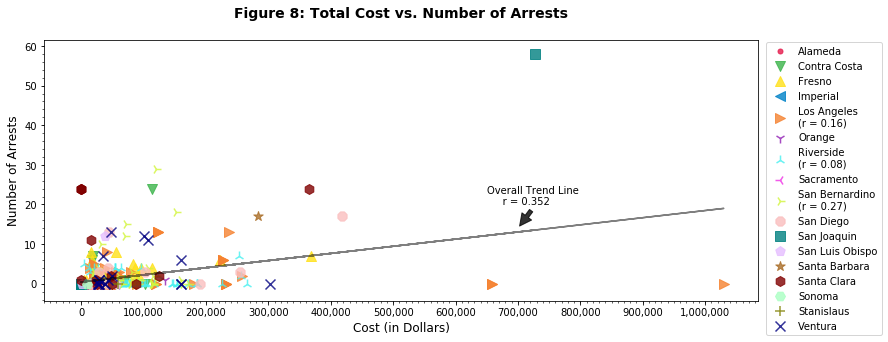

In [82]:
# Plot the arrest correlation chart
plt.figure(figsize=(12.8,4.8))

for jurisdiction in all_jurisdictions:
    
    jurisdiction_plot_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == jurisdiction, :]
    
    if pd.notnull(jurisdiction_data.get_value(jurisdiction,'arrest_corr')) == True:
        setlabel = jurisdiction + '\n(r = ' + str(round(jurisdiction_data.get_value(jurisdiction,'arrest_corr'),2)) + ')'
    else:
        setlabel = jurisdiction
    
    plt.scatter(jurisdiction_plot_slice['TotalCost'],
                jurisdiction_plot_slice['Arrested'], 
                alpha=0.8, 
                marker=jurisdiction_data.get_value(jurisdiction,'shape'),
                color=jurisdiction_data.get_value(jurisdiction,'color'),
                s=100, label=setlabel)

plt.plot(wt_data['TotalCost'],arrest_p(wt_data['TotalCost']),  alpha=.5, color='black')

plt.title('Figure 8: Total Cost vs. Number of Arrests\n', fontsize=14, fontweight='bold')
plt.ylabel('Number of Arrests', fontsize=12)
plt.xlabel('Cost (in Dollars)', fontsize=12)

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

trend_annotation = 'Overall Trend Line \n     r = ' + str(cost_arrest_r)
ax.annotate(trend_annotation,
            xy=(700000,14),
            xytext=(650000,20),
            arrowprops=dict(facecolor='black',
                            alpha=0.8,
                            shrink=0.1))

plt.legend(loc=1, bbox_to_anchor=(1.18,1.01))
plt.show()

##### Notable Findings:
* Wiretap operation cost in Riverside County is more strongly correlated with the interception of communications classed as incriminating than any other county (__r = 0.53__). However, no relationship was observed between total cost and number of arrests in Riverside County (__r = 0.08__).


* In Los Angeles County, no correlation was observed between wiretap operation cost and interception of communications classed as incriminating (__r = 0.04__), while a small correlation was observed between total operation cost and number of arrests made (__r = 0.16__).


* The three most expensive wiretapping cases in Los Angeles totaled __\$2,346,200__ in cost, accounting for __7.9%__ of all 2016 state and local-level wiretap spending in California. No arrests were made as a result of any of these cases.<br><br>

* Riverside County spent a total of __\$5,827,679__ on wiretapping in cases that led to 0 arrests. The majority of these cases were part of narcotics investigations.

### 3b: Arrests and Classification of Intercepted Communication as Incriminating

In 2016, __94.4%__ of California wiretap cases classified at least one intercepted communication as incriminating, and __776__ total arrests were made. However, the overwhelming majority of cases (__71.8%__) led to no arrests, and the majority of people surveilled (__63.2%__) were surveilled in cases that led to no arrests. Figure 11 visualizes the number and proportion of persons surveilled in cases that led to arrest and in cases that did not.

Figure 10 visualizes the relationship between arrest and incriminating classification as a 2x2 matrix. Critically, no relationship was observed between interception of incriminating communication via wiretap and arrest (__r = 0.08__). In fact, the majority (__67.1%__) of wiretap operations both classified at least one communication as incriminating and made __0__ arrests. The precise reason behind this lack of relationship is unknown and outside the scope of the data released by the CADOJ – perhaps the definition of "incriminating communication" is loosely applied, perhaps overclassification is incentivized, or perhaps these intercepted communications have limited value in court.

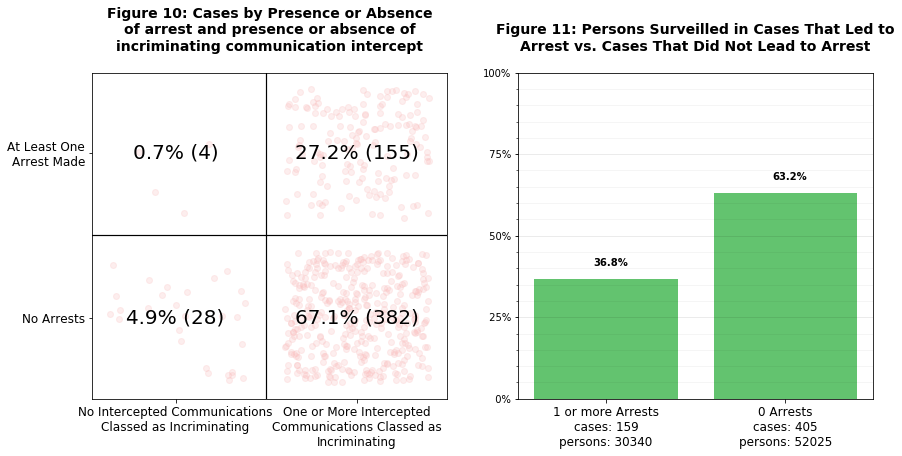

In [85]:

fig = plt.figure(figsize=(14,6))


# Crime

ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=wt_data['Incriminating_Binary'],
            y=wt_data['Arrested_Binary'],
            color='#fabebe',
            scatter_kws={'alpha':0.25},
            x_jitter=0.4,
            y_jitter=0.4,
            fit_reg=False)

plt.title('Figure 10: Cases by Presence or Absence\nof arrest and presence or absence of\nincriminating communication intercept\n', fontsize=14, fontweight='bold')

ax1.axvline(0.5, linestyle='-', color='black', lw=1.2)
ax1.axhline(0.5, linestyle='-', color='black', lw=1.2)


ax1.set_ylabel('')
ax1.set_xlabel('')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_ticklabels(['','No Intercepted Communications\nClassed as Incriminating', 'One or More Intercepted\nCommunications Classed as\nIncriminating'], size=12)

ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_ticklabels(['', 'No Arrests','At Least One\nArrest Made'], size=12)

arrested_true = wt_data.loc[lambda df: wt_data['Arrested_Binary'] == 1, :]
arrested_false = wt_data.loc[lambda df: wt_data['Arrested_Binary'] == 0, :]
total = wt_data.shape[0]

f_f = arrested_false.loc[lambda df: arrested_false['Incriminating_Binary'] == 0, :].shape[0]
plt.text(0,0, str(round(100*f_f/total,1)) + '%'+ ' (' +str(f_f) + ')', va='center', ha='center', size=20)
f_t = arrested_true.loc[lambda df: arrested_true['Incriminating_Binary'] == 0, :].shape[0]
plt.text(0,1, str(round(100*f_t/total,1)) + '%'+ ' (' +str(f_t) + ')', va='center', ha='center', size=20)
t_f = arrested_false.loc[lambda df: arrested_false['Incriminating_Binary'] == 1, :].shape[0]
plt.text(1,0, str(round(100*t_f/total,1)) + '%'+ ' (' +str(t_f) + ')', va='center', ha='center', size=20)
t_t = arrested_true.loc[lambda df: arrested_true['Incriminating_Binary'] == 1, :].shape[0]
plt.text(1,1, str(round(100*t_t/total,1)) + '%'+ ' (' +str(t_t) + ')', va='center', ha='center', size=20)

# Surveilled leading to arrest vs. surveilled leading to no arrests (bar chart)

pt_data = wt_data.drop(error_slice.index)

arrested_tf = ['1 or more Arrests', '0 Arrests']
cases_arrest = [pt_data.loc[lambda df: wt_data['Arrested_Binary'] == 1, :].shape[0],
                pt_data.loc[lambda df: wt_data['Arrested_Binary'] == 0, :].shape[0]]
persons_surv = [pt_data.loc[lambda df: wt_data['Arrested_Binary'] == 1, :]['Persons'].sum(),
                pt_data.loc[lambda df: wt_data['Arrested_Binary'] == 0, :]['Persons'].sum()]

arrest_surv = pd.DataFrame()
arrest_surv['arrested'] = arrested_tf
arrest_surv['cases'] = cases_arrest
arrest_surv['n_surveilled'] = persons_surv
arrest_surv['percent'] = arrest_surv['n_surveilled']/arrest_surv['n_surveilled'].sum()
arrest_surv['identifier'] = range(1, len(arrest_surv) + 1)
arrest_surv = arrest_surv.set_index('arrested')

ax2 = fig.add_subplot(1,2,2)
plt.bar(arrest_surv['identifier'],
        arrest_surv['percent'],
        color='#3cb44b',
        alpha=0.8)

plt.title('Figure 11: Persons Surveilled in Cases That Led to\nArrest vs. Cases That Did Not Lead to Arrest\n', fontsize=14, fontweight='bold')

arrested_labels = ['']
for var in arrest_surv.index:
    x = arrest_surv.get_value(var,'identifier')
    y = arrest_surv.get_value(var,'percent')
    label = str(round(arrest_surv.get_value(var,'percent')*100,1)) +'%'
    arrested_labels.append(str(var) + 
                           '\ncases: ' + 
                           str(int(arrest_surv.get_value(var,'cases'))) +
                           '\npersons: ' + 
                           str(int(arrest_surv.get_value(var,'n_surveilled'))) + '')
    plt.text(x+.025,y+.05,label,weight='semibold', va='center', ha='center')

    
    
ax2.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xticklabels(arrested_labels, size=12)

ax2.set_ylim(0,1)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(.25))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

plt.show()

### 3b: Spending by Alleged Offense and Number of Arrests

Figure 12 describes 2016 state and local-level California wiretap spending as it relates to alleged offense and number of arrests. Note that __62.8%__ of wiretap spending (__\$18,636,025__) occurred in cases where 0 arrests were made, and that __\$12,030,783__ of that spending was devoted to narcotics cases alone.


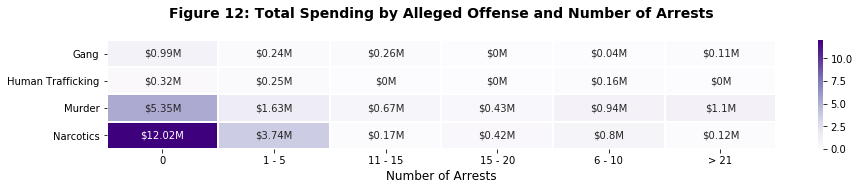

In [84]:
hm_data = wt_data[['Arrest_Recode', 'Offense', 'TotalCost']].copy()
hm_data['CostMil'] = round(hm_data['TotalCost']/1000000,2)
hm_data = pd.pivot_table(hm_data, 
                         values='CostMil',
                         index=['Offense'], 
                         columns=['Arrest_Recode'], 
                         aggfunc=np.sum).fillna(0)


fig = plt.figure(figsize=(15,2))

ax = sns.heatmap(hm_data,
                 annot=True,
                 fmt='g',
                 linewidths=1,
                 cmap='Purples')

for t in ax.texts: t.set_text('$' + t.get_text() + 'M')

plt.title('Figure 12: Total Spending by Alleged Offense and Number of Arrests\n', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlabel('Number of Arrests', fontsize=12)

    
plt.show()



<hr>

## <u>Conclusion</u>

California state-level wiretapping accounted for a large amount of law enforcement spending in 2016. Cell phones are a primary target for these operations, and large-scale surveillance authorizations are relatively commonplace. Although Los Angeles county is the largest spender on wiretapping, its per capita rates of authorization are roughly average for the state. Ventura, Fresno, and Imperial counties, on the other hand, all engage in unusually high rates of wiretapping. Despite repudiation from federal authorities and inconsistencies in data recording, wiretapping rates also continue to track as unusually high in Riverside county.

The concentration of financial resources on narcotics cases that do not lead to arrest and the lack of relationship between arrest and interception of incriminating communication both present concerns about the efficy of wiretapping as a law enforcement tool, and the large number of persons surveilled in the course of wiretapping operations presents ethics and privacy concerns (especially given the fact that the majority of wiretapping surveillance does not lead to arrest).

Future research should delve deeper into these issues by examining the county-level predictors of wiretapping rate and  the predictors of arrest in wiretapping cases. Although the CADOJ's practices have made previous years' data difficult to parse, there is also a need to incorporate all available data into a unified, long-term analysis of state-level wiretapping practices in California. 

<hr>

## <u>Bibliography</u>

Electronic Frontier Foundation. "California Finally Releases Wiretap Dataset." Electronic Frontier Foundation. https://www.eff.org/deeplinks/2017/06/california-finally-releases-wiretap-dataset (Accessed October 28, 2017)
    
Electronic Frontier Foundation. "California Wire Tapping." Kaggle. https://www.kaggle.com/eff/california-wire-tapping (Accessed October 28, 2017)

Kelman, Brett. "Judge: So many Riverside wiretaps, they can't be legal." USA Today. https://www.usatoday.com/story/news/crime_courts/2016/07/06/riverside-county-wiretaps-judge/86779116/ (Accessed October 28, 2017)